In [15]:
#custom neural networkx models
import neural_networks as ann
import utils
import gator #OUR IMPLEMENTATION OF CROCO
#other imports
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import seaborn as sns
from dataclasses import dataclass
from typing import List,Dict

In [63]:
from importlib import reload
gator = reload(gator)
utils = reload(utils)

In [17]:
@dataclass
class Simplex():
    counterfactuals:List
    weights:List[Dict]

In [4]:
#main model
conv_net = ann.ConvNet()
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()

#autoencoder
autoencoder = ann.Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder_checkpoint.pth'))
model.eval()

Sequential(
  (0): ConvNet(
    (conv_layers): Sequential(
      (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
      (4): Dropout(p=0.5, inplace=False)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): ReLU()
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=320, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (1): Extra_layer(
    (bin): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [35]:
# Specify the target digit for binary classification
batch_size_train = 128
batch_size_test = 1000
target_digit = 9
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

In [36]:
data_iter = enumerate(binary_test_loader)
batch_idx, (data, targets) = next(data_iter)
ones = (targets==1).nonzero()
x = data[ones[0]]

In [37]:
factuals = [img.detach() for img in data[ones[:5]]]

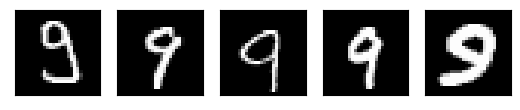

In [38]:
mosaic = """
ABCDE
"""

fig, axs = plt.subplot_mosaic(mosaic)

#plot factuals
for img,ax in zip(factuals,"ABCDE"):
    axs[ax].imshow(img.detach().view(28, 28), cmap='gray', interpolation='none')
    #predicted_class = torch.argmax(model(img.detach()), dim=1).item()
    #axs[ax].set_xlabel(f"Predicted Class: {predicted_class}",fontsize=7)
    #axs[ax].set_title(title)
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])
plt.show()

In [42]:
weights = [
    {"robustness":0.33,"validity":0.33,"proximity":0.33},
    {"robustness":0.1,"validity":0.1,"proximity":0.8},
    {"robustness":0.8,"validity":0.1,"proximity":0.1},
    {"robustness":0.1,"validity":0.8,"proximity":0.1},
]

simplices = []
for simplex in weights:
    counterfactuals=[]
    for factual in factuals:
        counterfactual, _ = gator.croco(
                        model=model,
                        autoencoder=None,
                        input_data=factual,
                        weights = simplex, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )
        counterfactuals.append(counterfactual)


    simplices.append(
        Simplex(
            counterfactuals = counterfactuals,
            weights = simplex)
    )

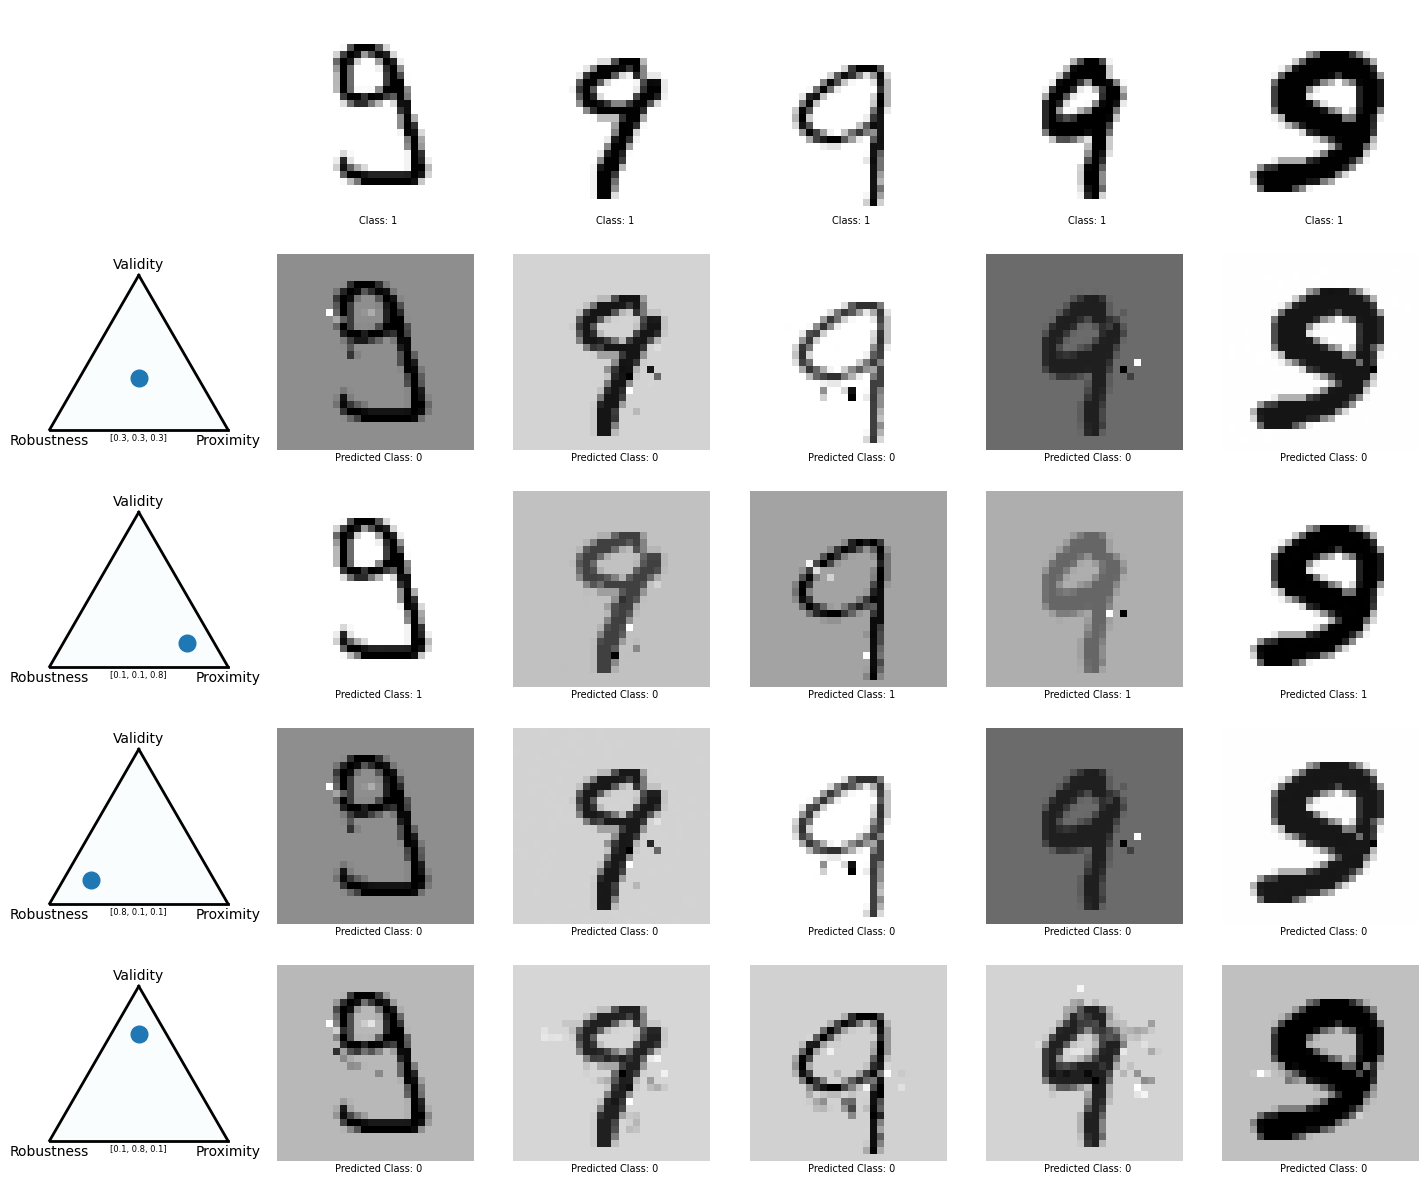

In [52]:
# Define the number of columns and total number of plots
num_cols = 6
num_rows = len(simplices)+1
# Create the plot
fig, axes = plt.subplots(num_rows, num_cols,figsize=(2.4*num_cols,2.4*num_rows))

axes[0,0].axis("off")
axes[0,0].set_xlabel("Counterfactuals")
axes[0,0].set_ylabel("Factuals")

#first row
for j in range(1,num_cols):
    axes[0, j].imshow(factuals[j-1].view(28, 28), cmap='gray_r', interpolation='none')
    axes[0, j].text(14,29,f"Class: 1",fontsize=7,ha="center")
    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])
    axes[0,j].axis("off")

# Loop through each row
for i in range(1,num_rows):
    # Loop through each column
    simplex = simplices[i-1]
    # triplot
    utils.tri_plot(simplex.weights,ax=axes[i,0])
    for j in range(1,num_cols):
        # Add your plotting code here for each subplot
        axes[i, j].imshow(simplex.counterfactuals[j-1].detach().view(28, 28), cmap='gray_r', interpolation='none')
        predicted_class = torch.argmax(model(simplex.counterfactuals[j-1].detach()), dim=1).item()
        axes[i, j].text(14,29,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i,j].axis("off")
        
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("figures/croco_exploration_standard.pdf")
plt.show()

In [81]:
weights = [
    {"robustness":33,"validity":33,"proximity":33},
    {"robustness":0.1,"validity":0.1,"proximity":0.8},
    {"robustness":80,"validity":1,"proximity":1},
    {"robustness":1,"validity":80,"proximity":1},
]

latent_simplices = []
for simplex in weights:
    counterfactuals=[]
    for factual in factuals:
        counterfactual, _ = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        input_data=factual,
                        weights = simplex, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )
        counterfactuals.append(counterfactual)


    latent_simplices.append(
        Simplex(
            counterfactuals = counterfactuals,
            weights = simplex)
    )

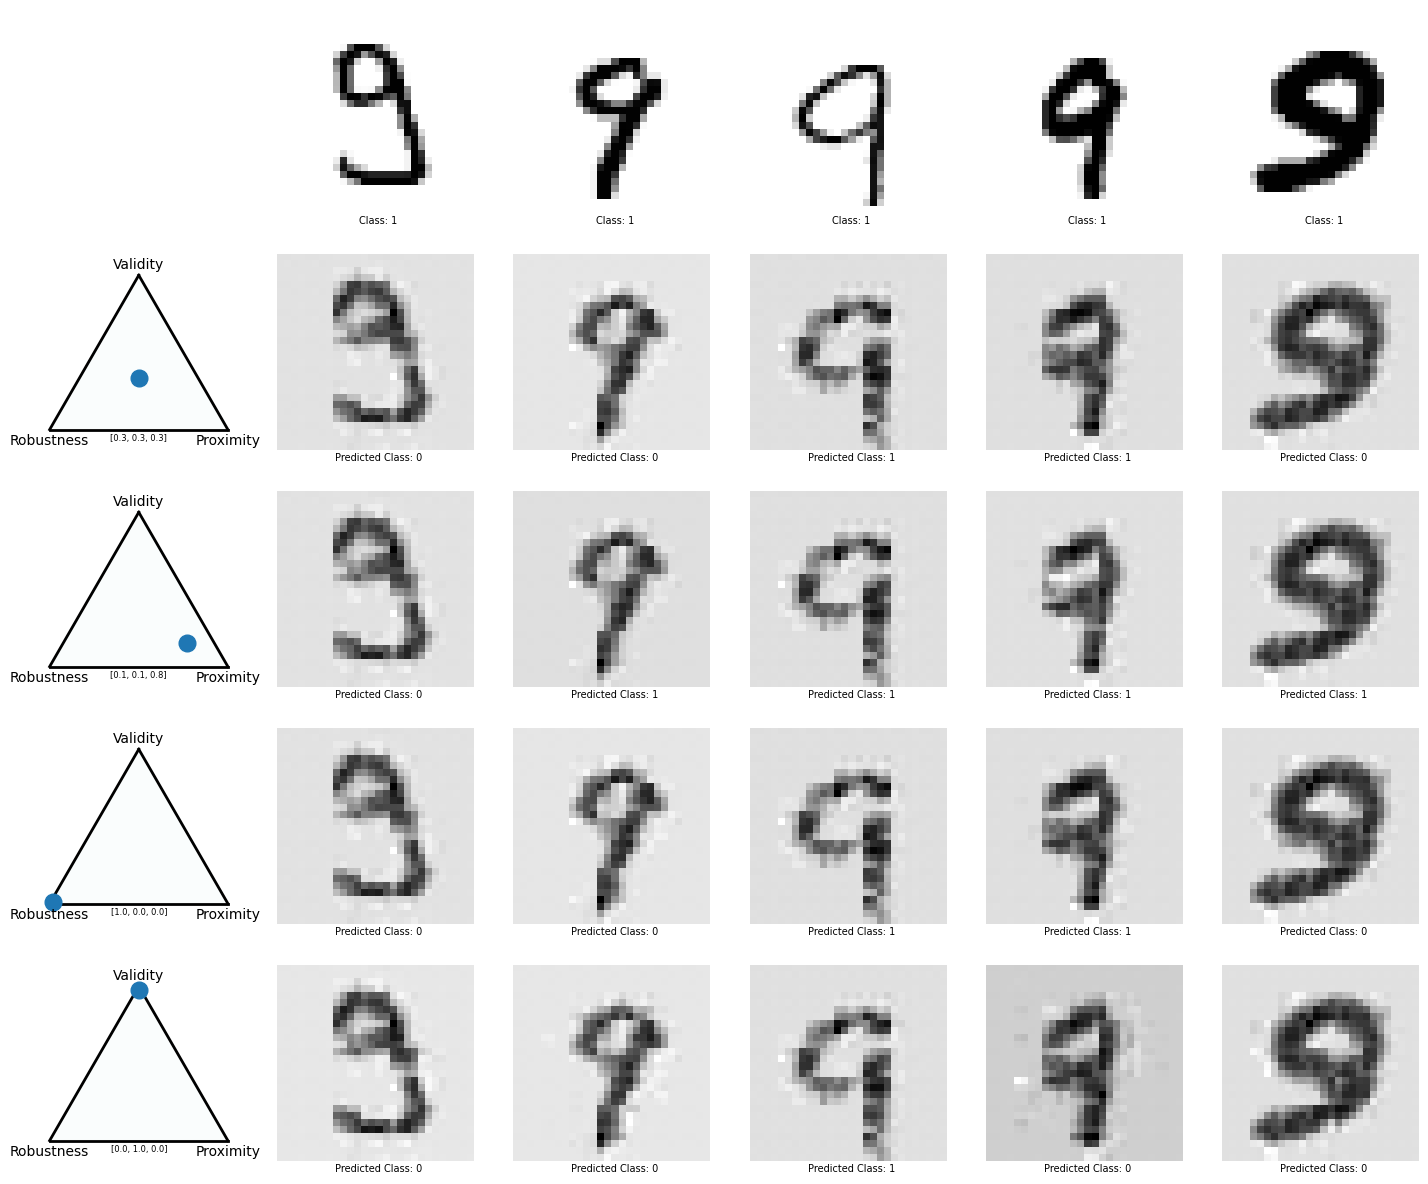

In [82]:
# Define the number of columns and total number of plots
num_cols = 6
num_rows = len(latent_simplices)+1
# Create the plot
fig, axes = plt.subplots(num_rows, num_cols,figsize=(2.4*num_cols,2.4*num_rows))

axes[0,0].axis("off")
axes[0,0].set_xlabel("Counterfactuals")
axes[0,0].set_ylabel("Factuals")

#first row
for j in range(1,num_cols):
    axes[0, j].imshow(factuals[j-1].view(28, 28), cmap='gray_r', interpolation='none')
    axes[0, j].text(14,29,f"Class: 1",fontsize=7,ha="center")
    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])
    axes[0,j].axis("off")

# Loop through each row
for i in range(1,num_rows):
    # Loop through each column
    simplex = latent_simplices[i-1]
    # triplot
    utils.tri_plot(simplex.weights,ax=axes[i,0])
    for j in range(1,num_cols):
        # Add your plotting code here for each subplot
        axes[i, j].imshow(simplex.counterfactuals[j-1].detach().view(28, 28), cmap='gray_r', interpolation='none')
        predicted_class = torch.argmax(model(simplex.counterfactuals[j-1].detach()), dim=1).item()
        axes[i, j].text(14,29,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i,j].axis("off")
        
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("figures/croco_exploration_latent.pdf")
plt.show()

# along a path

In [72]:
# Example usage:
s,t = [0.05, 90, 0.05],[90, 0.05, 0.05]
source = {"robustness":s[0],"validity":s[1],"proximity":s[2]}
target = {"robustness":t[0],"validity":t[1],"proximity":t[2]}
n_samples = 5
index = 0

path=[]

for (x,y,z) in utils.lerp(s, t, n_samples):
    simplex = {"robustness":x,"validity":y,"proximity":z}
    counterfactual, _ = gator.croco(
                        model=model,
                        autoencoder=None,
                        input_data=factuals[index],
                        weights = simplex, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )
    path.append(counterfactual)

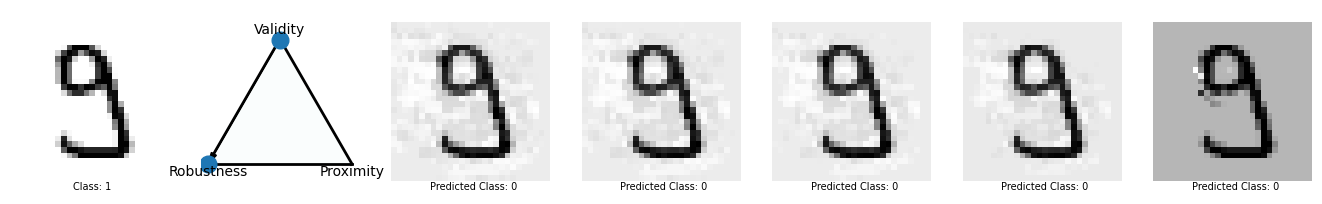

In [78]:
mosaic = "ABCDEFG"
fig,axs = plt.subplot_mosaic(mosaic,figsize=(2.4*7,2.4))

#first print factual
axs["A"].imshow(factuals[index].view(28, 28), cmap='gray_r', interpolation='none')
axs["A"].text(14,29,f"Class: 1",fontsize=7,ha="center")
axs["A"].set_xticks([])
axs["A"].set_yticks([])
axs["A"].axis("off")
#print triangle:
utils.tri_plot_arrow(source, target, axs["B"])
#print path
for counterfactual, ax in zip(path, "CDEFG"):
        axs[ax].imshow(counterfactual.detach().view(28, 28), cmap='gray_r', interpolation='none')
        predicted_class = torch.argmax(model(counterfactual.detach()), dim=1).item()
        axs[ax].text(14,29,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
        axs[ax].set_xticks([])
        axs[ax].set_yticks([])
        axs[ax].axis("off")
plt.savefig("figures/croco_path_standard.pdf")
plt.show()

### latent

In [83]:
# Example usage:
s,t = [0.05, 90, 0.05],[90, 0.05, 0.05]
source = {"robustness":s[0],"validity":s[1],"proximity":s[2]}
target = {"robustness":t[0],"validity":t[1],"proximity":t[2]}
n_samples = 5
index = 0

latent_path=[]

for (x,y,z) in utils.lerp(s, t, n_samples):
    simplex = {"robustness":x,"validity":y,"proximity":z}
    counterfactual, _ = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        input_data=factuals[index],
                        weights = simplex, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )
    latent_path.append(counterfactual)

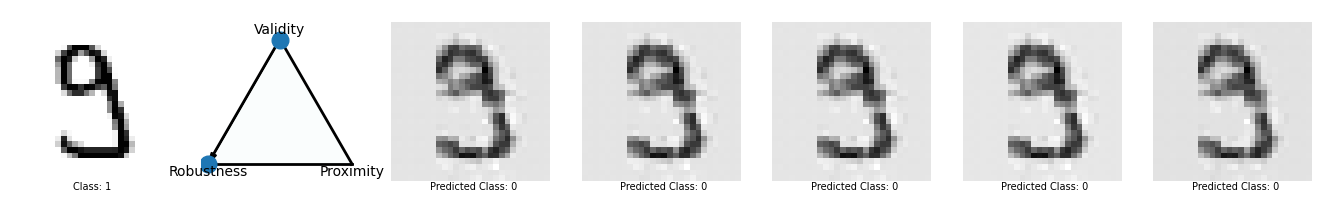

In [84]:
mosaic = "ABCDEFG"
fig,axs = plt.subplot_mosaic(mosaic,figsize=(2.4*7,2.4))

#first print factual
axs["A"].imshow(factuals[index].view(28, 28), cmap='gray_r', interpolation='none')
axs["A"].text(14,29,f"Class: 1",fontsize=7,ha="center")
axs["A"].set_xticks([])
axs["A"].set_yticks([])
axs["A"].axis("off")
#print triangle:
utils.tri_plot_arrow(source, target, axs["B"])
#print path
for counterfactual, ax in zip(latent_path, "CDEFG"):
        axs[ax].imshow(counterfactual.detach().view(28, 28), cmap='gray_r', interpolation='none')
        predicted_class = torch.argmax(model(counterfactual.detach()), dim=1).item()
        axs[ax].text(14,29,f"Predicted Class: {predicted_class}",fontsize=7,ha="center")
        axs[ax].set_xticks([])
        axs[ax].set_yticks([])
        axs[ax].axis("off")
plt.savefig("figures/croco_path_latent.pdf")
plt.show()

In [12]:
factual = data[ones[17]].clone().detach()

counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=None,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

latent_counterfactual, hist = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        input_data=factual,
                        weights = {"robustness":0.5,"validity":1,"proximity":0.01}, #robustness, validity, proximity
                        sigma2=0.2,
                        max_iter = 1000,
                        learning_rate=0.01,
                        n_samples=500,
                        device = "cpu"
                        )

# Illustrations

In [85]:
batch_size_train = 128
batch_size_test = 1000


train_loader = DataLoader(MNIST('mnist_data/', train=True, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = DataLoader(MNIST('mnist_data/', train=False, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [106]:
data,targets = [],[]
for batch_idx, (data_, targets_) in enumerate(binary_test_loader):
    if batch_idx>3:
        break
    data.extend([row.flatten() for row in data_.detach().numpy()])
    targets.extend(targets_.detach().numpy())

In [119]:
import umap.umap_ as umap

embedding = umap.UMAP(n_neighbors=5).fit_transform(data,y = targets)

In [120]:
def select_points_minmax(points, n):
    selected_indexes = []
    remaining_indexes = set(range(len(points)))

    # Find the point with the maximum distance to the current selection
    def find_farthest_point(selected_indexes):
        distances = np.min(np.linalg.norm(points[selected_indexes][:, np.newaxis] - points, axis=-1), axis=0)
        return np.argmax(distances)

    # Start with a random point
    current_index = np.random.choice(list(remaining_indexes))
    selected_indexes.append(current_index)
    remaining_indexes.remove(current_index)

    # Add points until reaching the desired number
    while len(selected_indexes) < n:
        farthest_index = find_farthest_point(selected_indexes)
        selected_indexes.append(farthest_index)
        remaining_indexes.remove(farthest_index)

    return selected_indexes

In [121]:
from dbsampler import dbs

indexes = select_points_minmax(embedding, 100)
boundary = np.array(dbs(embedding,targets,n_points=1000))

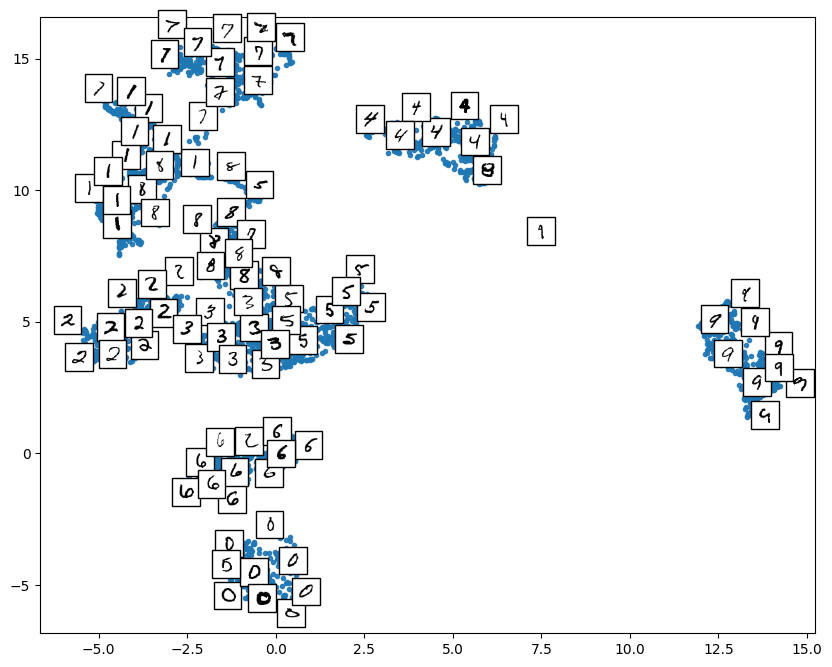

In [130]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(embedding[:,0],embedding[:,1],marker=".",alpha=0.9)
for i in indexes:
    x, y = embedding[i]
    image = data[i]
    im = OffsetImage(image.reshape((28,28)), zoom=0.5,cmap='gray_r')
    im.image.axes = ax

    ab = AnnotationBbox(im, (x,y),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.3,
                        frameon=True)
    ax.add_artist(ab)
#ax.scatter(boundary[:,0],boundary[:,1],c='k',marker=".")
plt.show()

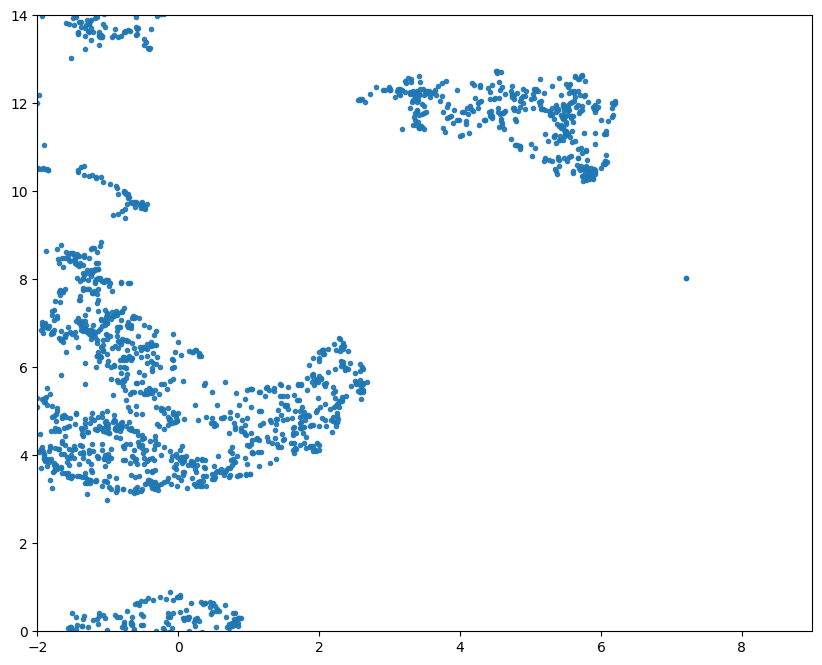

In [142]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(embedding[:,0],embedding[:,1],marker=".",alpha=0.9)
for i in indexes:
    x, y = embedding[i]
    image = data[i]
    im = OffsetImage(image.reshape((28,28)), zoom=0.5,cmap='gray_r')
    im.image.axes = ax

    ab = AnnotationBbox(im, (x,y),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.3,
                        frameon=True)
    #ax.add_artist(ab)
#ax.scatter(boundary[:,0],boundary[:,1],c='k',marker=".")
plt.ylim(0,14)
plt.xlim(-2,9)
plt.show()

# Alibi attempt

In [88]:
!pip install alibi[torch]

     |████████████████████████████████| 522 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 41.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 64.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 54.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 72.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 85.2 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 79.7 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 494 kB 90.8 MB/s eta 0:00:01
     |████████████████████████████████| 934 kB 93.1 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 807 kB/s  eta 0:00:01
     |████████████████████████████████| 154 kB 95.6 MB/s eta 0:00:01
     |█████████████████████████████

     |████████████████████████████████| 45 kB 4.1 MB/s  eta 0:00:01
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.2
    Uninstalling pydantic-2.6.2:
      Successfully uninstalled pydantic-2.6.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

openai 1.12.0 requires typing-extensions<5,>=4.7, but you'll have typing-extensions 4.5.0 which is incompatible.
huggingface-hub 0.21.3 requires fsspec>=2023.5.0, but you'll have fsspec 0.8.3 which is incompatible.


In [93]:
from alibi.explainers import Counterfactual

In [101]:
X = factual.clone().detach()

In [105]:
shape = X.numpy().shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (0.1307, 0.3081)

In [106]:
cf = Counterfactual(model, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
explainer = CounterfactualRL(predictor=predictor,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             latent_dim=LATENT_DIM,
                             train_steps=1000,
                             batch_size=100,
                             backend="tensorflow")

AttributeError: 'Autoencoder' object has no attribute 'decoder'